---

<h1><center>SDSE Lab 2 <br><br> Gradient descent and <br> Stochastic Gradient Descent </center></h1>

---

Note: The format for the report is as a Jupyter Notebook. Please include the section number and SIDs of the members of your group in the results dictionary. A single notebook should be submitted as a group submission in Gradescope. 

In [1]:
result = {
    'section_number' : ['Helen Bergstrom', 'Cassie Young', 'Elvis Lo'], # enter your student id here
    'SIDs': [3033625729,0,0] # enter the SIDs for the group members
}

# Introduction

In this lab we will explore the gradient descent and stochastic gradient descent algorithms for solving a least squares optimization problem. The setup is as follows. We wish to model a process with scalar input $X$ and scalar output $Y$. Both of these are real-valued random variables; their sample spaces are the real line. The joint distribution of $X$ and $Y$ is given as:
\begin{align*}
X &\sim \mathcal{U}(0,1) \\
Y|X\!=\!x &\sim \mathcal{N}( \theta_0 + \theta_1 x ,\sigma^2_\epsilon)
\end{align*}
This definition of $Y|X\!=\!x$ is equivalent to,
\begin{equation*}
Y = \theta_0 + \theta_1 X + \epsilon
\end{equation*}
with $\epsilon\sim\mathcal{N}(0,\sigma^2_\epsilon)$.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import scipy.stats as stats

# 1. Sampling the joint distribution

We will first construct a synthetic dataset by sampling  from $(X,Y)$. 

## (1a)

Write a function called `sampleXY` that produces a dataset $\{(x_n,y_n)\}_N$ of iid samples from $(X,Y)$, given arguments $N$, $\theta_0$, $\theta_1$, and $\sigma^2_\epsilon$. The output of this function should be a numpy array with shape = $(N,2)$. 

In [3]:
def sampleXY(N, theta0, theta1, sigma2_eps):
    samples = np.empty((N,2))
    X = np.random.uniform(0.0,1.0,N)
    Y = theta0 + theta1*X + np.random.normal(0,sigma2_eps,N)
    samples = [X,Y]
    return samples    
   
    #pass

In [4]:
N = 40
theta0=0.2
theta1=-0.4
sigma_eps=np.sqrt(0.0049)
XYsamp = sampleXY(N, theta0, theta1, sigma_eps)

Run `sampleXY` with $N\!=\!40$, $\theta_0\!=\!0.2$, $\theta_1\!=\!-0.4$, and $\sigma^2_\epsilon\!=\!0.0049$ and assign the result to the variable `XYsamp`. Create a plot showing the line $y=\theta_0 + \theta_1 x$, overlaid with a scatter plot of `XYsamp`. The plot should have labels on the x and y axes. (4 pts)

<function matplotlib.pyplot.show(close=None, block=None)>

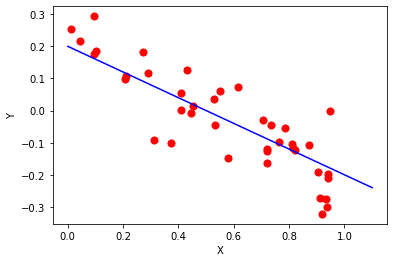

In [5]:
x = np.arange(0,1.2,0.1)
y = theta0 + theta1*x
fig1 = plt.figure()
plt.scatter(XYsamp[0],XYsamp[1], color='red', marker="o",s=50)
plt.plot(x,y, marker = 'None', color = 'b', linestyle='-')
plt.xlabel('X')
plt.ylabel('Y')
plt.show


In [6]:
################################
# Reporting. Do not modify.#####
result['fig1'] = fig1
################################

We will now overwrite the data you sampled with another dataset contained in the file `1d_data.pickle`. This is so the results are predictable.

In [7]:
with open('./1d_data.pickle', 'rb') as file:
    XYsamp = pickle.load(file)

# 2. Least squares linear regression

We will now produce estimates of $\theta_0$ and $\theta_1$ corresponding to the least squares estimate of a straigt line fitted to `XYsamp`. The model in this case is:

\begin{equation*}
\hat y(x) = h(x;\hat\theta_0,\hat\theta_1) =  \hat\theta_0 +  \hat\theta_1 x
\end{equation*}


The error for each sample is the squared difference between the sampled and modeled values:
\begin{equation*}
\ell_n(\hat\theta_0,\hat\theta_1) = \left( \hat y(x_n) - y_n \right)^2 = (\hat \theta_0 + \hat \theta_1 \: x_n - y_n)^2 
\end{equation*}

Notice a slightly confusing but crucial point: We are considering the error for the $n$'th sample ($\ell_n$) as a function of the parameter estimates $\hat\theta_0$ and $\hat\theta_1$, with "parameters" $x_n$ and $y_n$, whereas the model $h$ is a function of $x$ with parameters $\hat\theta_0$ and $\hat\theta_1$. The roles of "input" and "parameter" are inverted. 

We define the matrix $\Phi\in\mathbb{R}^{N\times 2}$ such that the model can be written in matrix form:
\begin{equation*}
\mathbf{\hat Y} = \Phi \: \hat\theta 
\end{equation*}
where 
\begin{equation*}
\hat\theta = \begin{bmatrix}\hat\theta_0 \\ \hat\theta_1 \end{bmatrix} \hspace{3em} \text{and} \hspace{3em}
\mathbf{\hat Y} = \begin{bmatrix} \hat y(x_1) \\ \vdots \\ \hat y(x_N) \end{bmatrix} 
\end{equation*}


The total loss for candidate parameters $\hat\theta_0$ and $\hat\theta_1$ is defined as the sum of the losses for each sample:
\begin{equation*}
L(\hat\theta_0, \hat\theta_1) \;=\; \sum_{n=1}^{N} \ell_n(\hat\theta_0, \hat\theta_1) \;=\; \sum_{n=1}^{N} \left( \hat y(x_n) - y_n \right)^2 \;=\; \lvert\lvert \Phi \hat\theta-\mathbf{Y} \rvert\rvert^2_2
\end{equation*}

Thus the problem of finding the least squares estimates of $\theta_0$ and $\theta_1$ can be written as:
\begin{align*}
&\underset{\hat\theta_0,\: \hat\theta_1}{\text{minimize}} \: L(\hat\theta_0, \hat\theta_1) \\
\equiv \quad
&\underset{\hat\theta_0,\: \hat\theta_1}{\text{minimize}} \:
\sum_{n=1}^{N} \ell_n(\hat\theta_0, \hat\theta_1)
\\
\equiv \quad
&\underset{\hat\theta_0, \:\hat\theta_1}{\text{minimize}} \: \sum_{n=1}^{N} \left( \hat\theta_0 + \hat \theta_1 \:x_n - y_n \right)^2 \\
\equiv \quad
&\underset{\hat\theta}{\text{minimize}} \: \lvert\lvert \Phi \hat\theta-\mathbf{Y} \rvert\rvert^2_2
\end{align*}


## (2a)

Write a function called `solve_lr` that takes `XYsamp` as input, constructs $\Phi$ and $\mathbf{Y}$, and finds the exact solution to the least squares problem using the formula,
\begin{equation*}
\hat\theta = (\Phi^T \Phi)^{-1}\Phi^T \mathbf{Y}
\end{equation*}
This function should return the solution as a numpy array of length 2 with $\hat\theta_0$ in the zeroth position and $\hat\theta_1$ in the first position. (4 points)

In [8]:
#def solve_lr(XYsamp):
#    pass

In [9]:
################################
# Reporting. Do not modify.#####
#result['theta_2a'] = solve_lr(XYsamp)
################################

# 3. Gradient descent

We will now write an iterative numerical algorithm for solving the least squares problem. We take the objective function of the problem to be:
\begin{equation*}
J(\hat\theta_0,\hat\theta_1) = \sum_{n=1}^{N} \left( \hat\theta_0 + \hat \theta_1 \:x_n - y_n \right)^2
\end{equation*}

## (3a)

Write a function called `nablaJ` that takes `XYsamp`, $\hat\theta_0$, and $\hat\theta_1$ as inputs, and returns the gradient as a numpy array of length 2.

In [10]:
def nablaJ(XYsamp, theta0, theta1):
    dJdtheta0 = 2*(theta0 + theta1*XYsamp[:,0] - XYsamp[:,1])*1
    dJdtheta1 = 2*(theta0 + theta1*XYsamp[:,0] - XYsamp[:,1])*XYsamp[:,0]
    grad = np.array([dJdtheta0.sum(),dJdtheta1.sum()])
    return grad
   

In [11]:
nab = nablaJ(XYsamp, theta0, theta1)
print(nab)

[0.01411023 0.16865593]


In [12]:
################################
# Reporting. Do not modify.#####
result['nablaJ_3a_a'] = nablaJ(XYsamp,0.5,-1)
result['nablaJ_3a_b'] = nablaJ(XYsamp,1.1,0.6)
print(result['nablaJ_3a_a'])
print(result['nablaJ_3a_b'])
################################

[ 0.23092068 -3.85312911]
[111.65275948  62.36573994]


## (3b)

Write a function called `gradient_descent` that executes the gradient descent algorithm. This function should take as input 

+ The dataset `XYsamp`
+ the total number of steps to take $K$
+ the step size $\gamma$
+ the initial condition Theta0 as a numpy array of length 2. 

It should return the trajectory as a with shape = `(K,2)`. (8 pts)

In [13]:
def gradient_descent(XYsamp,K,gamma,Theta0):
    gamma = gamma/N
    trajectory = np.empty((K,2)) #create an empty trajectory
    trajectory[0,:] = Theta0
    for k in range(K-1):
        trajectory[k+1,:]=trajectory[k,:]-gamma*nablaJ(XYsamp,trajectory[k,0],trajectory[k,1])
    return trajectory
   

In [14]:
################################
# Reporting. Do not modify.#####
result['gd_3b_a'] = gradient_descent(XYsamp,10,0.1,np.array([-0.5,0.5]))
result['gd_3b_b'] = gradient_descent(XYsamp,20,0.01,np.array([0.5,-0.5]))
################################

## (3c)

Complete the `run_gd_on_grid(theta0_grid,theta1_grid,K,gamma)`. This function takes as input
+ `theta0_grid` and `theta1_grid`. These are a 5x5 grid of values of $\hat\theta_0$ and $\hat\theta_1$. 
+ `K`: the number of steps to take, and
+ `gamma`: the step size. 

The function should return a numpy array with shape (5,5,K,2), where the (i,j,:,:) is a (K,2) trajectory of parameter values. 

Run the function with $K=200$, $\gamma=0.2$ and save the result to `trajectories`.

Note: The code for creating the 5x5 grid is provided. 

(8 pts)

In [15]:
# Do not alter this code. It creates the 5x5 grid of values 
# that are passed to `run_gd_on_grid`
def make_grid(gridN):
    theta_0_array = np.linspace(-1,1,gridN)
    theta_1_array = np.linspace(-1,1,gridN)
    return  np.meshgrid(theta_0_array,theta_1_array)

gridN = 5
theta0_grid,theta1_grid = make_grid(gridN)

In [16]:
def run_gd_on_grid(XYsamp,theta0_grid,theta1_grid,K,gamma):
    trajectory = np.empty((5,5,K,2))
    for i in range(theta0_grid.shape[0]):
        for j in range(theta0_grid.shape[1]):
            trajectory[i,j,:,:] = gradient_descent(XYsamp,K,gamma,Theta0=[theta0_grid[i,j], theta1_grid[i,j]]) 
    return trajectory

trajectories =  run_gd_on_grid(XYsamp,theta0_grid,theta1_grid,K=200,gamma=0.2)
  

In [17]:
################################
# Reporting. Do not modify.#####
result['grid_3c'] = run_gd_on_grid(XYsamp,theta0_grid,theta1_grid,K=200,gamma=0.2)
################################

## (3d)

Complete the function below that plots the error vectors for each of the 25 trajectories in a single plot. The error for each trajectory is an array of length 200, with the $k$'th element computed as:
\begin{equation*}
e_k := \sqrt{ (\hat\theta_{0,k}-\theta_0)^2 + (\hat\theta_{1,k}-\theta_1)^2 } 
\end{equation*}
Here $k\in[1,...,K]$ is the gradient descent iteration step. Plot all 25 of them on a single plot with the iteration index on the x axis and the logarithm of the error on the y axis. (8 pts) 

In [18]:
theta0_real=0.2
theta1_real=-0.4
               
def plot_error(trajectories):
    errors= np.empty((5,5,200,1))
    errors= np.sqrt((trajectories[:,:,:,0]-theta0_real)**2 + ((trajectories[:,:,:,1]-theta1_real)**2))
    fig = plt.figure(figsize=(8,8));
    plt.xlabel('iteration index',fontsize=15);
    plt.ylabel('log(errors)',fontsize=15);
    for i in range(errors.shape[0]):
        for j in range(errors.shape[1]):
            plt.plot(np.arange(0,errors.shape[2]),np.log(errors[i,j,:]));
    return fig


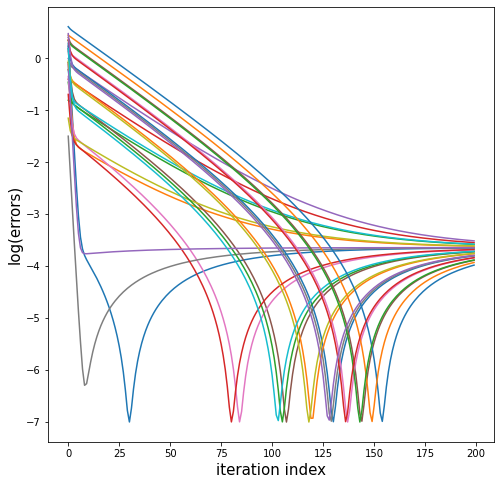

In [19]:
################################
# Reporting. Do not modify.#####
result['fig_3d'] = plot_error(result['grid_3c'])
################################

## (3e)

The `plot_quiver` function shown below creates an image of the $\nabla_\theta J$ as a vector field and returns the figure handle. 

Your task is to complete `plot_traj`. This function takes the existing figure handle as input (provided by `plot_quiver`) and should overlay it with the 25 trajectories obtained with gradient descent. Each trajectory should be plotted with a thin red line. `plot_traj` should then return the same figure handle. (6 pts)

In [20]:
def plot_quiver():
    
    gridN = 10
    theta0_grid, theta1_grid = make_grid(gridN)
    flatgrid = np.reshape([theta0_grid, theta1_grid],(2,gridN**2)).T
    UV = np.empty(flatgrid.shape)
    for i, (theta0z, theta1z) in enumerate(flatgrid):
        UV[i,:] = nablaJ(XYsamp,theta0z, theta1z)
    
    fig = plt.figure(figsize=(8,8))
    plt.quiver(flatgrid[:,0], flatgrid[:,1],-UV[:,0],-UV[:,1],scale=30*N)
    
    plt.xlabel('theta0',fontsize=15)
    plt.ylabel('theta1',fontsize=15)
    plt.plot(theta0,theta1,'o',markersize=16)
    plt.axis([-1,1,-1,1])
    return fig

In [21]:
def plot_traj(fig,trajectories):  
    plt.figure(fig)
    for i in range(trajectories.shape[0]):
        for j in range(trajectories.shape[1]):
            matrix = trajectories[i,j,:,:]
            plt.plot(matrix[:,0],matrix[:,1], color='red')
            plt.scatter(matrix[0,0], matrix[0,1], color = 'green', zorder=2)
                                
    return fig

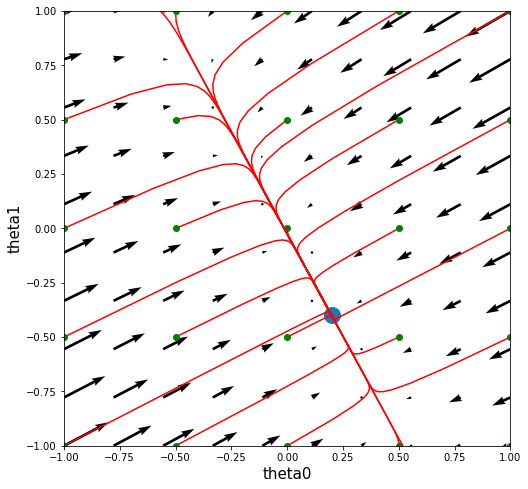

In [22]:
################################
# Reporting. Do not modify.#####
result['fig_3e'] = plot_traj(plot_quiver(),result['grid_3c'])
################################

## (3f)

Repeat parts (d) and (e) with $\gamma=0.01$ and $\gamma=0.7$. (0 pts)
Note: This part is not awarded points. It is simply for you to appreciate the effect of the step size.

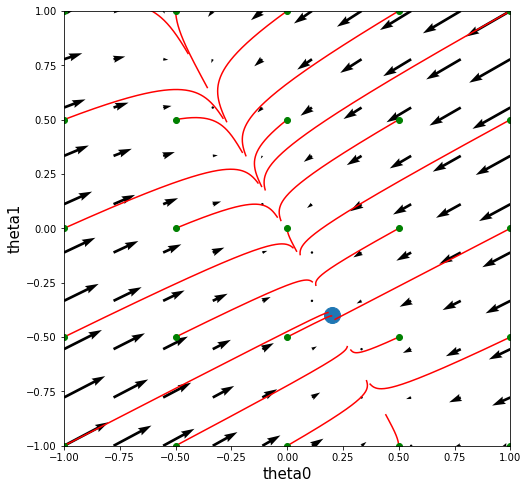

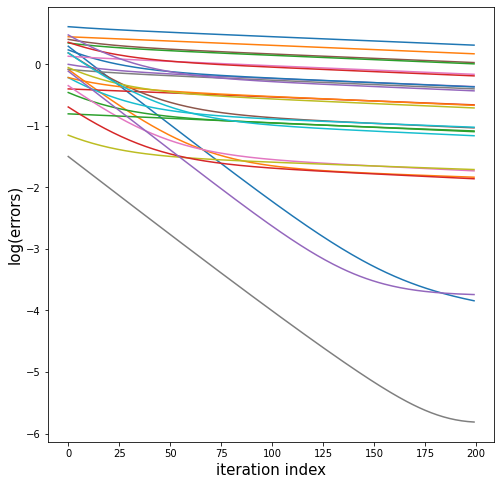

In [23]:
################################
# Reporting. Do not modify.#####
trajectories2 = run_gd_on_grid(XYsamp,theta0_grid,theta1_grid ,K=200,gamma=0.01)
result['fig_3fA_phase'] = plot_traj(plot_quiver(),trajectories2)
result['fig_3fA_error'] = plot_error(trajectories2)
################################

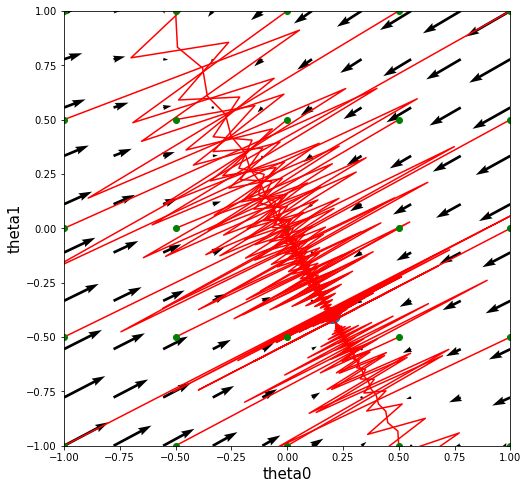

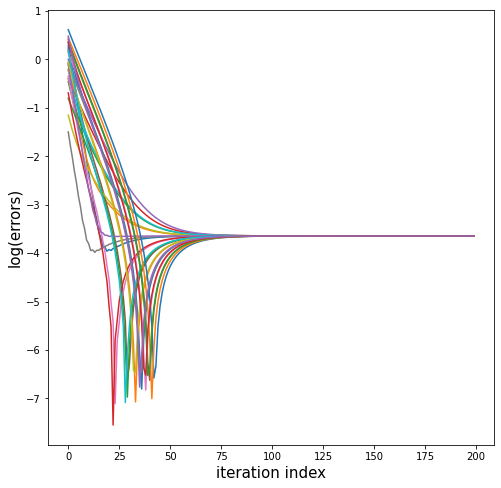

In [24]:
################################
# Reporting. Do not modify.#####
trajectories3 = run_gd_on_grid(XYsamp,theta0_grid,theta1_grid ,K=200,gamma=0.7)
result['fig_3fB_phase'] = plot_traj(plot_quiver(),trajectories3)
result['fig_3fB_error'] = plot_error(trajectories3)
################################

# 4. Additive cost

The deliverable for this part is a single plot is in the $\theta_0, \theta_1$ plane. The limits should be from -1 to 1 along both axes, as in previous parts. The plot should have these elements. (10 pts)

+ For each sample $n$, draw a thin black line in the parameter space corresponding to $\ell_n=0$. There should be a total of $N=40$ lines. 
+ Place a small dot at the intersection of every line. There will be a total of $N(N-1)/2$ such dots. Briefly explain the interpretation of these intersections. 
+ Plot a large dot at the location of the true parameter values. 
+ Overylay one of the gradient descent trajectories from part 3.

Save the handle of the figure in the variable `fig4`. This will be added to the results dictionary.

## 4 answer
each intersction of lines in theta0-theta1 space represent pairs of theta0 and theta1 that have 0 loss for two data points

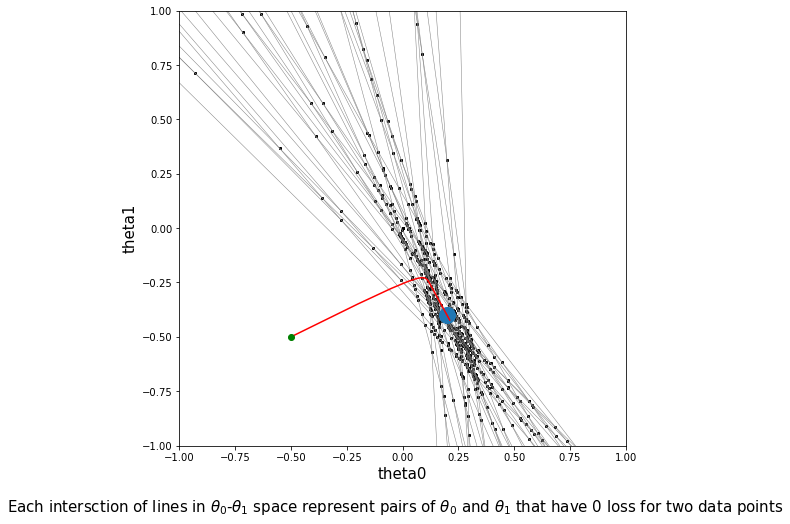

In [267]:
fig4=plt.figure(figsize=(8,8))


thet0=np.arange(-1,1,0.05)
line_params = np.empty((XYsamp.shape))
for i in range(XYsamp[:,0].size):
    line_params[i,0] = (XYsamp[i,1]/XYsamp[i,0])
    line_params[i,1]= -(1/XYsamp[i,0])
    thet1 = (line_params[i,1]*thet0 + line_params[i,0])
    plt.plot(thet0,thet1, color='grey',linewidth=0.5)

xi = np.zeros((line_params.shape[0],line_params.shape[0]))
yi = np.zeros((line_params.shape[0],line_params.shape[0]))

for i in range(line_params.shape[0]):
    for j in range(line_params.shape[0]):
        if i==j:
            continue
        xi[i,j] = (line_params[i,0]-line_params[j,0]) / (line_params[j,1]-line_params[i,1])
        yi[i,j] = line_params[i,1] * xi[i,j] + line_params[i,0]

plt.scatter(xi,yi, color='black', marker='o',s=4)


plt.plot(theta0,theta1,'o',markersize=16)

#if we want to plot just one trajectory
matrix = trajectories[1,1,:,:]
plt.plot(matrix[:,0],matrix[:,1], color='red')
plt.scatter(matrix[0,0], matrix[0,1], color = 'green', zorder=2)

#if we want to plot all the trajectories
#plot_traj(fig4,trajectories)

plt.xlabel('theta0',fontsize=15)
plt.ylabel('theta1',fontsize=15)
plt.axis([-1,1,-1,1]);
plt.figtext(0.5, 0.01, r'Each intersction of lines in $\theta_0$-$\theta_1$ space represent pairs of $\theta_0$ and $\theta_1$ that have 0 loss for two data points', ha="center", fontsize=15);


In [26]:
################################
# Reporting. Do not modify.#####
result['fig4'] = fig4
################################

# 5. Stochastic Gradient Descent

## 5(a)

(10 pts) Code stochastic gradient descent. Complete the function `SGD` below. This function takes as arguments 
+ the dataset `XYsamp`, 
+ the step size $\gamma$ and 
+ the number of epochs to run. 

`SGD` function should

+ randomly choose the initial condition with uniform probability from $[-1,1]\times[-1,1]$
+ use batches of size 1,
+ draw samples without replacement.

The function should return the parameter trajectory. 


Run SGD with $\gamma=0.1$ and 10 epochs. Recreate the plot from part 4 but using this SGD trajectory instead of GD. Save the figure handle as `fig5a`.

In [218]:
def nablaJ_sgd(XYsamp, theta0, theta1):
    dJdtheta0 = 2*(theta0 + theta1*XYsamp[0] - XYsamp[1])*1
    dJdtheta1 = 2*(theta0 + theta1*XYsamp[0] - XYsamp[1])*XYsamp[0]
    grad = np.array([dJdtheta0,dJdtheta1])
    return grad

In [229]:
def SGD(XYsamp,gamma,epochs):
    N = XYsamp.shape[0]
    gamma = gamma
    trajectory = np.empty((epochs*N+1,2))
    trajectory[0,:] = stats.uniform(-1,1).rvs(2)

    for k in range(N):
        grad = nablaJ_sgd(XYsamp[k,:],trajectory[k,0],trajectory[k,1])
        for j in range(epochs): 
            np.random.shuffle(XYsamp)
            trajectory[(k*epochs+j)+1,:]=trajectory[(k*epochs+j),:]-gamma*nablaJ_sgd(XYsamp[k,:],trajectory[(k*epochs+j),0],trajectory[(k*epochs+j),1])  
        
    return trajectory


In [230]:
sgd_trajectory = SGD(XYsamp, gamma=0.1, epochs=10)

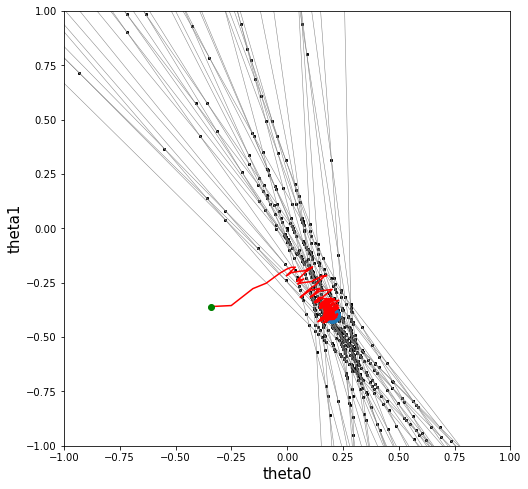

In [231]:
fig5a=plt.figure(figsize=(8,8))


thet0=np.arange(-1,1,0.05)
line_params = np.empty((XYsamp.shape))
for i in range(XYsamp[:,0].size):
    line_params[i,0] = (XYsamp[i,1]/XYsamp[i,0])
    line_params[i,1]= -(1/XYsamp[i,0])
    thet1 = (line_params[i,1]*thet0 + line_params[i,0])
    plt.plot(thet0,thet1, color='grey',linewidth=0.5)

xi = np.zeros((line_params.shape[0],line_params.shape[0]))
yi = np.zeros((line_params.shape[0],line_params.shape[0]))

for i in range(line_params.shape[0]):
    for j in range(line_params.shape[0]):
        if i==j:
            continue
        xi[i,j] = (line_params[i,0]-line_params[j,0]) / (line_params[j,1]-line_params[i,1])
        yi[i,j] = line_params[i,1] * xi[i,j] + line_params[i,0]

plt.scatter(xi,yi, color='black', marker='o',s=4)


plt.plot(theta0,theta1,'o',markersize=16)

#if we want to plot just one trajectory
plt.plot(sgd_trajectory[:,0],sgd_trajectory[:,1], color='red')
plt.scatter(sgd_trajectory[0,0], sgd_trajectory[0,1], color = 'green', zorder=2)

#if we want to plot all the trajectories
#plot_traj(fig4,trajectories)

plt.xlabel('theta0',fontsize=15)
plt.ylabel('theta1',fontsize=15)
plt.axis([-1,1,-1,1]);

In [235]:
################################
# Reporting. Do not modify.#####
result['fig5a'] = fig5a
################################

## 5(b)

Make the same plot with $\gamma=0.01$ and $\gamma=0.4$. Save the figure handles respectively as `fig5b1` and `fig5b2`. (6 pts) 

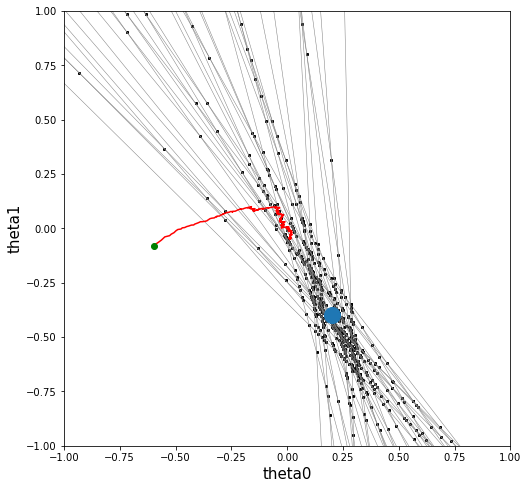

In [232]:
sgd_trajectory1 = SGD(XYsamp, gamma=0.01, epochs=10)
fig5b1 = plt.figure(figsize=(8,8))
thet0=np.arange(-1,1,0.05)
line_params = np.empty((XYsamp.shape))
for i in range(XYsamp[:,0].size):
    line_params[i,0] = (XYsamp[i,1]/XYsamp[i,0])
    line_params[i,1]= -(1/XYsamp[i,0])
    thet1 = (line_params[i,1]*thet0 + line_params[i,0])
    plt.plot(thet0,thet1, color='grey',linewidth=0.5)

xi = np.zeros((line_params.shape[0],line_params.shape[0]))
yi = np.zeros((line_params.shape[0],line_params.shape[0]))

for i in range(line_params.shape[0]):
    for j in range(line_params.shape[0]):
        if i==j:
            continue
        xi[i,j] = (line_params[i,0]-line_params[j,0]) / (line_params[j,1]-line_params[i,1])
        yi[i,j] = line_params[i,1] * xi[i,j] + line_params[i,0]

plt.scatter(xi,yi, color='black', marker='o',s=4)


plt.plot(theta0,theta1,'o',markersize=16)

#if we want to plot just one trajectory
plt.plot(sgd_trajectory1[:,0],sgd_trajectory1[:,1], color='red')
plt.scatter(sgd_trajectory1[0,0], sgd_trajectory1[0,1], color = 'green', zorder=2)

#if we want to plot all the trajectories
#plot_traj(fig4,trajectories)

plt.xlabel('theta0',fontsize=15)
plt.ylabel('theta1',fontsize=15)
plt.axis([-1,1,-1,1]);



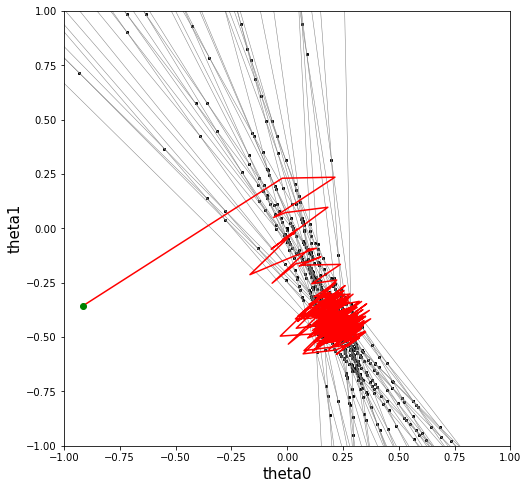

In [233]:
sgd_trajectory1 = SGD(XYsamp, gamma=0.4, epochs=10)
fig5b2 = plt.figure(figsize=(8,8))
thet0=np.arange(-1,1,0.05)
line_params = np.empty((XYsamp.shape))
for i in range(XYsamp[:,0].size):
    line_params[i,0] = (XYsamp[i,1]/XYsamp[i,0])
    line_params[i,1]= -(1/XYsamp[i,0])
    thet1 = (line_params[i,1]*thet0 + line_params[i,0])
    plt.plot(thet0,thet1, color='grey',linewidth=0.5)

xi = np.zeros((line_params.shape[0],line_params.shape[0]))
yi = np.zeros((line_params.shape[0],line_params.shape[0]))

for i in range(line_params.shape[0]):
    for j in range(line_params.shape[0]):
        if i==j:
            continue
        xi[i,j] = (line_params[i,0]-line_params[j,0]) / (line_params[j,1]-line_params[i,1])
        yi[i,j] = line_params[i,1] * xi[i,j] + line_params[i,0]

plt.scatter(xi,yi, color='black', marker='o',s=4)


plt.plot(theta0,theta1,'o',markersize=16)

#if we want to plot just one trajectory
plt.plot(sgd_trajectory1[:,0],sgd_trajectory1[:,1], color='red')
plt.scatter(sgd_trajectory1[0,0], sgd_trajectory1[0,1], color = 'green', zorder=2)

#if we want to plot all the trajectories
#plot_traj(fig4,trajectories)

plt.xlabel('theta0',fontsize=15)
plt.ylabel('theta1',fontsize=15)
plt.axis([-1,1,-1,1]);

In [234]:
################################
# Reporting. Do not modify.#####
result['fig5b1'] = fig5b1
result['fig5b2'] = fig5b2
################################

## 5(c)

Comment on the pros and cons of SGD with respect to GD. Save your comments in a string called `comment`. (6 pts) 

In [ ]:
comment = ''

In [ ]:
################################
# Reporting. Do not modify.#####
result['comment'] = comment
################################

---
## Do not modify below this

In [ ]:
with open('{}.pickle'.format("_".join([str(sid) for sid in result['SIDs']])),'wb') as file:
    pickle.dump(result,file)